# Respiration Rate Project 

# This project is based on this paper: https://pubmed.ncbi.nlm.nih.gov/33175740/

# 1. Import needed libraries

In [1]:
import numpy as np
import cv2, math, dlib, time
from scipy import signal
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk
from tkinter import filedialog
import tkinter as tk

# 2. Define function to capture live video

In [2]:
def capture_video(duration=30):
    cap = cv2.VideoCapture(0)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 30
    out = cv2.VideoWriter('live_video.mp4', fourcc, fps, (640, 480))
    start_time = time.time()
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            out.write(frame)
            cv2.imshow('frame', frame)
            if cv2.waitKey(1) & 0xFF == ord('q') or time.time() - start_time >= duration:
                break
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# 3. Define function to calculate BPM

In [3]:
def analyze_video(points=None, path=None):
        video_capture = cv2.VideoCapture(path)  
        fps = video_capture.get(cv2.CAP_PROP_FPS)  

        face_detector = dlib.get_frontal_face_detector()
        points = (0, 0, 0, 0) 

        # Capture video frames and perform analysis
        video_capture = cv2.VideoCapture(path)  
        fps = video_capture.get(cv2.CAP_PROP_FPS)  
        num_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))  
        while video_capture.isOpened():  
            ret, frame = video_capture.read()  
            if not ret: 
                break
            faces = face_detector(frame) 
            for face in faces: 
                face_left = face.left()
                face_right = face.right()
                face_top = face.top()
                face_bottom = face.bottom()
                length = face_bottom - face_top
                width = face_right - face_left
                x3 = math.ceil(face_left - (0.75 * width))
                x4 = math.ceil(face_right + (0.75 * width))
                y3 = math.ceil(face_bottom + (0.3 * length))
                y4 = math.ceil(y3 + length)
                chest_width = x4 - x3 
                chest_height = y4 - y3 
                cv2.rectangle(frame, (face_left, face_top), (face_right, face_bottom), (255, 0, 0), 2) 
                cv2.rectangle(frame, (x3, y3), (x4, y4), (255, 0, 0), 2) 
                points = (x3, y3, chest_width, chest_height) 
            cv2.imshow("frame", frame)  
            if cv2.waitKey(1) == 27:  
                break
        video_capture.release()  
        cv2.destroyAllWindows() 

        # Capture processed video and calculate metrics
        video_capture = cv2.VideoCapture(path)  
        video_codec = cv2.VideoWriter_fourcc(*'mp4v') 
        output_video = cv2.VideoWriter('output/output.mp4', video_codec, 60, (chest_width, chest_height)) 
        sum_val_list = []  
        x, y, w, h = points

        while video_capture.isOpened(): 
            ret, frame = video_capture.read()  
            if not ret:  
                break

            cropped_frame = frame[y:y+h, x:x+w]  
            output_video.write(cropped_frame) 
            sum_values = np.sum(cropped_frame) 
            sum_val_list.append(sum_values)  
            normalized_data = (sum_val_list - np.min(sum_val_list)) / (np.max(sum_val_list) - np.min(sum_val_list))

            cv2.imshow('Cropped Video', cropped_frame)  
            if cv2.waitKey(1) == 27:
                break

        video_capture.release()  
        output_video.release() 
        cv2.destroyAllWindows() 

        # Perform signal processing and analysis
        data = normalized_data  
        sampling_rate = 30
        nyquist_freq = 0.5 * sampling_rate  
        lowcut = 0.16 / nyquist_freq  
        highcut = 0.5 / nyquist_freq  
        filter_order = 5
        b, a = signal.butter(filter_order, [lowcut, highcut], btype='band')  
        filtered_data = signal.filtfilt(b, a, data) 
        peaks, _ = find_peaks(filtered_data) 
        time_length = num_frames / fps 
        respiration_rate = math.ceil((len(peaks) / time_length) * 60)  
        result_label.config(text="Respiration Rate (BPM): {}".format(respiration_rate))

        fig, ax = plt.subplots(figsize=(8, 4))  
        ax.plot(filtered_data, label='Filtered Signal')  
        ax.plot(peaks, filtered_data[peaks], "x", label='Peaks', color='red') 
        ax.set_title('Filtered Signal with Detected Peaks')
        ax.legend()  
        ax.set_xlabel('Sample')  
        ax.set_ylabel('Normalized Output')

        canvas = FigureCanvasTkAgg(fig, master=root) 
        canvas.draw()  
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

# 4. Additional Functions

### 4.1 **Select Function:** Analyze any video on PC.

### 4.2 **Live Video Function:** Capture real-time video and then analyze it.


In [4]:
def select_video():
    path = filedialog.askopenfilename(filetypes=[("Video files", "*.avi;*.mp4;*.MOV")])
    if path:
        analyze_video(path=path)

def analyze_live_video():
    capture_video(duration=30)
    analyze_video(path='live_video.mp4')

# 5. GUI part

C:\Users\Yousef\AppData\Local\Temp\ipykernel_15952\720851810.py:55: RuntimeWarning: invalid value encountered in divide
  normalized_data = (sum_val_list - np.min(sum_val_list)) / (np.max(sum_val_list) - np.min(sum_val_list))


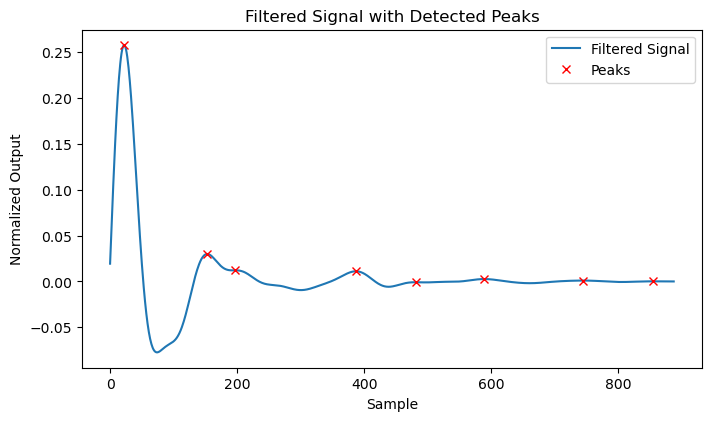

In [5]:
root = tk.Tk()
root.title("Video Analysis")
root.geometry("800x600")

bg_image = Image.open("18143510_1006.webp")
bg_photo = ImageTk.PhotoImage(bg_image)

background_label = tk.Label(root, image=bg_photo)
background_label.place(x=0, y=0, relwidth=1, relheight=1)

select_button = tk.Button(root, text="Select Video", command=select_video, bg="blue", fg="white", padx=10, pady=5)
select_button.pack(pady=10)

live_button = tk.Button(root,text="Live Video", command=analyze_live_video, bg="green", fg="white", padx=10, pady=5)
live_button.pack(pady=10)

result_label = tk.Label(root,text="", font=("Arial", 18))
result_label.pack(pady=10)

root.mainloop()